# Introduction
This is the submission for the European Regional Data Open 2020 organised by Citadel/Citadel Securities and Correlation One. It was awarded 3rd Place in the competition.

Team members: Xinyi Xu, Sean Nassimiha, Joel Perez and Pei Dong.

## Background
Gentrification is the process of changing the character of a neighbourhood through the influx of more affluent residents and businesses. Although at first glance it seems very positive, it is actually a controversial topic in politics and urban planning. It is unquestionable that a neighbourhood can benefit from physical improvements of its buildings or the creation of new business; however, gentrification normally comes at the price of the displacement (or replacement) of the working-class population by the new middle class as the cost of living in the area tends to increase.

## Problem statement
Our goal was to use census data for every tract in the New York-Newark-Jersey City, NY-NJ-PA
Metropolitan Statistical Area (MSA) in order to discover and analyze patterns related to the
gentrification process. 

We were allowed to formulate our own question and we decided to study the possibility of **Investment without displacement** and therefore the **factors that enable it**.

## Load up data

In [ ]:
import pandas as pd
import glob, os    
import numpy as np

In [ ]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "CensusWithIndustry/*.csv"))))

## Initial feature engineering 
We will create new features from already existing features.

In [ ]:
df['Percentage low income households'] = (df['Low income households']/df['Total all income households'])*100
df['Percentage college educated'] = ((df['Men with Bachelors degree'] + df['Women with Bachelors degree'])/(df['Total women with any studies'] + df['Total men with any studies']))*100
df['Percentage renters'] = (df['Rented households']/df['All households '])*100
df['Percentage nonwhite'] = 100 - (df['White people']/df['All races'])*100

In [ ]:
base = df[df['year'] == 2009]
final = df[df['year'] == 2018]
base = base.set_index('geoid')
final = final.set_index('geoid')

# Definitions
We will use the classification method used in the [New York Urban Displacement Project](http://www.udpny.org/), and for that we will generate the following definitions.

### Vulnerable

In [ ]:
affordable = base[base['Median household value'] < 0.8*base['Median household value'].median()].index.to_list()
li = base[base['Percentage low income households'] > base['Percentage low income households'].median()].index.to_list()
not_educated = base[base['Percentage college educated'] < base['Percentage college educated'].median()].index.to_list()
most_renters = base[base['Percentage renters'] > base['Percentage renters'].median()].index.to_list()
nonwhites = base[base['Percentage nonwhite'] > base['Percentage nonwhite'].median()].index.to_list()

In [ ]:
d = {}
for geoid in affordable:
    d[geoid] = 0
    for filt in [li, not_educated, most_renters, nonwhites]:
        if geoid in filt:
            d[geoid] += 1
    if d[geoid] < 3:
        d.pop(geoid)

In [ ]:
vulnerablesBase = list(d.keys())

In [ ]:
print('Affordable', len(affordable))
print('Vulnerables', len(vulnerablesBase))

Affordable 1112
Vulnerables 584


In [ ]:
affordable = final[final['Median household value'] < 0.8*final['Median household value'].median()].index.to_list()
li = final[final['Percentage low income households'] > final['Percentage low income households'].median()].index.to_list()
not_educated = final[final['Percentage college educated'] < final['Percentage college educated'].median()].index.to_list()
most_renters = final[final['Percentage renters'] > final['Percentage renters'].median()].index.to_list()
nonwhites = final[final['Percentage nonwhite'] > final['Percentage nonwhite'].median()].index.to_list()

In [ ]:
d = {}
for geoid in affordable:
    d[geoid] = 0
    for filt in [li, not_educated, most_renters, nonwhites]:
        if geoid in filt:
            d[geoid] += 1
    if d[geoid] < 3:
        d.pop(geoid)

In [ ]:
vulnerablesFinal = list(d.keys())

In [ ]:
print('Affordable', len(affordable))
print('Vulnerables', len(vulnerablesFinal))

Affordable 1559
Vulnerables 781


### Hot market

In [ ]:
rent_change = (final['Median gross rent'] - base['Median gross rent']).dropna()
hot_rent = rent_change[rent_change > rent_change.median()].index.to_list()

In [ ]:
value_change = (final['Median household value'] - base['Median household value']).dropna()
hot_value = value_change[value_change > value_change.median()].index.to_list()

In [ ]:
hot_market = list(set(hot_rent) | set(hot_value))

In [ ]:
print('Hot market', len(hot_market))

Hot market 2788


### Demographic change

In [ ]:
ed_change = (final['Percentage college educated'] - base['Percentage college educated']).dropna()
more_educated = ed_change[ed_change > ed_change.median()].index.to_list()

income_change = (final['Median household income'] - base['Median household income']).dropna()
wealthier = income_change[income_change > income_change.median()].index.to_list()

demographic_change = list(set(more_educated) & set(wealthier))

### Gentrified

In [ ]:
gentrified = list(set(vulnerablesBase) & set(demographic_change) & set(hot_market))

In [ ]:
print('Gentrified', len(gentrified))

Gentrified 63


### Improvement

In [ ]:
investment = list(set(vulnerablesBase) & set(hot_market))
investment = [x for x in investment if x not in gentrified]
investment = [x for x in investment if x not in vulnerablesFinal]

In [ ]:
len(investment)

92

# Classification
Now that we have made basic definitions, we can move on to classify the tracts.

### Ongoing Displacement of Low-income households 

In [ ]:
populated = base[base['All households '] > 500].index.to_list()
median_low_income_pct = final['Percentage low income households'].median()
poor = final[final['Percentage low income households'] > median_low_income_pct].index.to_list()
li_change = (final['Percentage low income households'] - base['Percentage low income households']).dropna()
li = li_change[li_change < 0.0].index.to_list()

In [ ]:
odlih = list(set(populated) & set(poor) & set(li))
odlih = [x for x in odlih if x not in gentrified]

In [ ]:
print('Ongoing displacement of low-income households', len(odlih))

Ongoing displacement of low-income households 686


### Ongoing gentrification

In [ ]:
populated = base[base['All households '] > 500].index.to_list()
median_low_income_pct = final['Percentage low income households'].median()
poor = final[final['Percentage low income households'] > median_low_income_pct].index.to_list()

In [ ]:
og = list(set(populated) & set(poor) & set(gentrified))

In [ ]:
print('Ongoing gentrification', len(og))

Ongoing gentrification 49


### At risk of gentrification

In [ ]:
populated = base[base['All households '] > 500].index.to_list()
mean_low_income_pct = final['Percentage low income households'].mean()
poor = final[final['Percentage low income households'] > mean_low_income_pct].index.to_list()
#vulnerablesFinal
#hot_market

In [ ]:
arg = list(set(populated) & set(poor) & set(vulnerablesFinal) & set(hot_market))
arg = [x for x in arg if x not in odlih]
arg = [x for x in arg if x not in og]

In [ ]:
print('At risk of gentrification', len(arg))

At risk of gentrification 106


### Advanced gentrification

In [ ]:
populated = base[base['All households '] > 500].index.to_list()
median_low_income_pct = final['Percentage low income households'].median()
rich = final[final['Percentage low income households'] < median_low_income_pct].index.to_list()

In [ ]:
ag = list(set(populated) & set(rich) & set(gentrified))

In [ ]:
print('Advanced gentrification', len(ag))

Advanced gentrification 13


### Ongoing Exclusion

In [ ]:
populated = base[base['All households '] > 500].index.to_list()
median_low_income_pct = final['Percentage low income households'].median()
rich = final[final['Percentage low income households'] < median_low_income_pct].index.to_list()
li_change = (final['Percentage low income households'] - base['Percentage low income households']).dropna()
li = li_change[li_change < 0.0].index.to_list()

In [ ]:
oe = list(set(populated) & set(li) & set(rich))

In [ ]:
print('Ongoing exclusion', len(oe))

Ongoing exclusion 878


### Stable exclusion

In [ ]:
populated = base[base['All households '] > 500].index.to_list()
median_low_income_pct = final['Percentage low income households'].median()
rich = final[final['Percentage low income households'] < median_low_income_pct].index.to_list()

In [ ]:
se = list(set(populated) & set(rich))
se = [x for x in se if x not in oe]

In [ ]:
print('Stable exclusion', len(se))

Stable exclusion 1079


### Super Gentrification or Exclusion

In [ ]:
populated = base[base['All households '] > 500].index.to_list()
superrich = final[final['Median household income'] > 2*final['Median household income'].median()].index.to_list()

In [ ]:
se = list(set(populated) & set(superrich))

In [ ]:
print('Super gentrification or Exclusion', len(se))

Super gentrification or Exclusion 257


### Not losing low-income households

In [ ]:
populated = base[base['All households '] > 500].index.to_list()
mean_low_income_pct = final['Percentage low income households'].mean()
poor = final[final['Percentage low income households'] > mean_low_income_pct].index.to_list()
not_losing = list(set(populated) & set(poor) & set(vulnerablesBase))

In [ ]:
nl = [x for x in not_losing if x not in arg]
nl = [x for x in nl if x not in og]
nl = [x for x in nl if x not in se]
nl = [x for x in nl if x not in oe]
nl = [x for x in nl if x not in ag]

In [ ]:
print("Not losing", len(nl))

Not losing 281


### Investment without displacement
This is our new classification, that describes an area that started as a vulnerable tract but saw an improvement of its condition without a demographic change.

In [ ]:
iwd = (list(set(investment) & set(nl)))
print("Investment without displacement", len(iwd))

Investment without displacement 66


## Focus of our investigation
For our project, we focused on observing the tracts that were classified as *Ongoing Gentrification* (OG), *Advanced Gentrification* (AG) and *Investment Without Displacement* (IWD)

In [ ]:
print('Ongoing gentrification', len(og))
print('Advanced gentrification', len(ag))
print("Investment without displacement", len(iwd))

Ongoing gentrification 49
Advanced gentrification 13
Investment without displacement 66


In [ ]:
investment_without_displacement = [[x, 'IWD'] for x in iwd]
ongoing_gentrification = [[x, 'OG'] for x in og]
advanced_gentrification = [[x, 'AG'] for x in ag]
total = investment_without_displacement+ongoing_gentrification+advanced_gentrification

In [ ]:
types = pd.DataFrame(total, columns = ['geoid', 'Type']).set_index('geoid')

In [ ]:
base['Type'] = types
final['Type'] = types

In [ ]:
interestingB = base[base['Type'].notna()].sort_values(by='Type')
interestingF = final[final['Type'].notna()].sort_values(by='Type')

# Data Exploration
With the data prepared, we can now start exploring our dataset.

### Demographic change in interesting tracts
As a sanity check, we are going to first ensure that our classifications are coherent and we spot clear differences in the demographic changes.

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

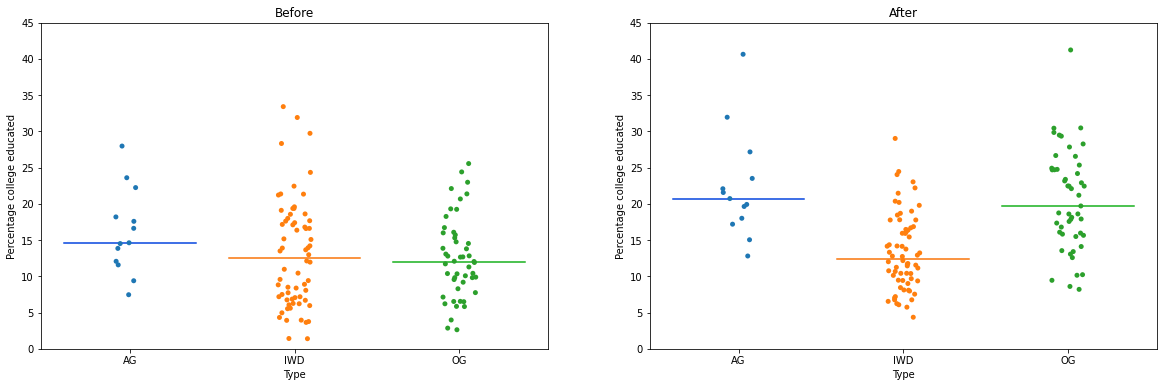

In [ ]:
ag1_med = interestingB.loc[interestingB["Type"] == 'AG'].median()['Percentage college educated']
iwd1_med = interestingB.loc[interestingB["Type"] == 'IWD'].median()['Percentage college educated']
og1_med = interestingB.loc[interestingB["Type"] == 'OG'].median()['Percentage college educated']
fig, ax =plt.subplots(1,2, figsize= (20, 6))
a = sns.stripplot(y='Percentage college educated', x='Type', data=interestingB, ax=ax[0])
a.set_title('Before')
a.set_ylim([0, 45])
x = a.get_xlim()# how to plot median line?
a.plot([-0.4, 0.4], len(x) * [ag1_med], sns.xkcd_rgb["blue"])
a.plot([0.6,1.4], len(x) * [iwd1_med], sns.xkcd_rgb["orange"])
a.plot([1.6,2.4], len(x) * [og1_med], sns.xkcd_rgb["green"])#calc median
ag2_med = interestingF.loc[interestingF["Type"] == 'AG'].median()['Percentage college educated']
iwd2_med = interestingF.loc[interestingF["Type"] == 'IWD'].median()['Percentage college educated']
og2_med = interestingF.loc[interestingF["Type"] == 'OG'].median()['Percentage college educated']
b = sns.stripplot(y='Percentage college educated', x='Type', data=interestingF, ax=ax[1])
b.set_title('After')
b.set_ylim([0, 45])
y = b.get_xlim()# how to plot median line?
b.plot([-0.4, 0.4], len(y) * [ag2_med], sns.xkcd_rgb["blue"])
b.plot([0.6,1.4], len(y) * [iwd2_med], sns.xkcd_rgb["orange"])
b.plot([1.6,2.4], len(y) * [og2_med], sns.xkcd_rgb["green"])

(0.0, 100.0)

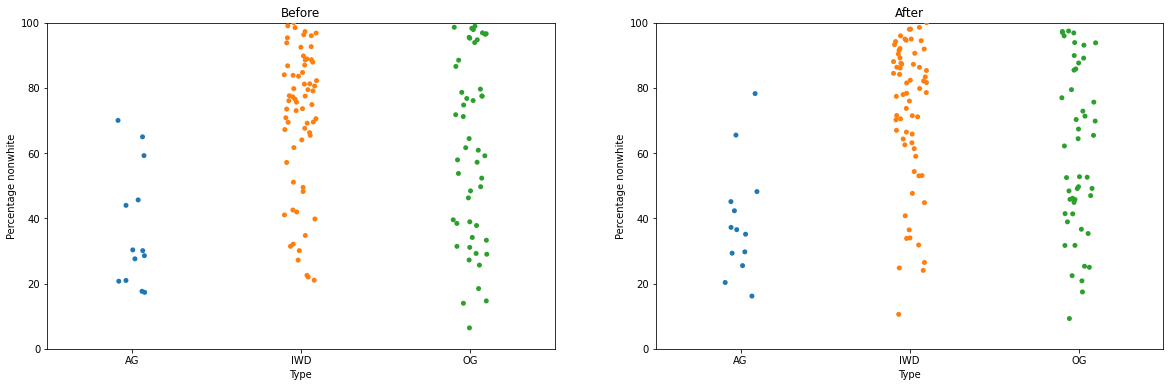

In [ ]:
fig, ax =plt.subplots(1,2, figsize= (20, 6))
a = sns.stripplot(y='Percentage nonwhite', x='Type', data=interestingB, ax=ax[0])
a.set_title('Before')
a.set_ylim([0, 100])
b = sns.stripplot(y='Percentage nonwhite', x='Type', data=interestingF, ax=ax[1])
b.set_title('After')
b.set_ylim([0, 100])

(0.0, 100.0)

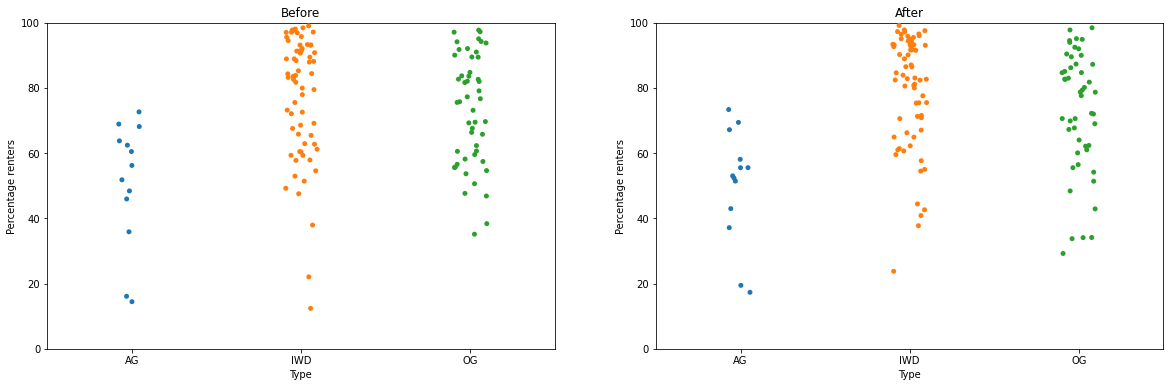

In [ ]:
fig, ax =plt.subplots(1,2, figsize= (20, 6))
a = sns.stripplot(y='Percentage renters', x='Type', data=interestingB, ax=ax[0])
a.set_title('Before')
a.set_ylim([0, 100])
b = sns.stripplot(y='Percentage renters', x='Type', data=interestingF, ax=ax[1])
b.set_title('After')
b.set_ylim([0, 100])

(0.0, 60.0)

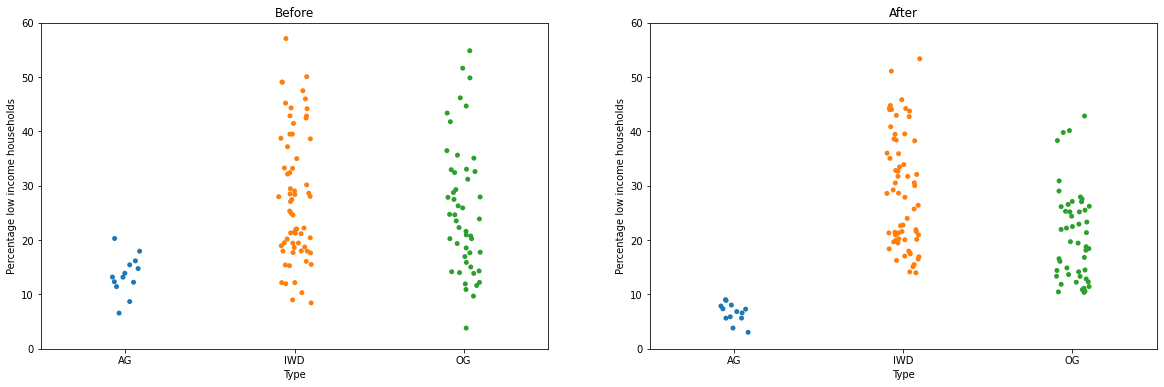

In [ ]:
fig, ax =plt.subplots(1,2, figsize= (20, 6))
a = sns.stripplot(y='Percentage low income households', x='Type', data=interestingB, ax=ax[0])
a.set_title('Before')
a.set_ylim([0, 60])
b = sns.stripplot(y='Percentage low income households', x='Type', data=interestingF, ax=ax[1])
b.set_title('After')
b.set_ylim([0, 60])

In [ ]:
cInterestingB = interestingB.copy()
cInterestingB['Type'] = cInterestingB['Type'].apply(lambda x: 'OG' if (x=='AG' or x=='OG') else 'IWD') 

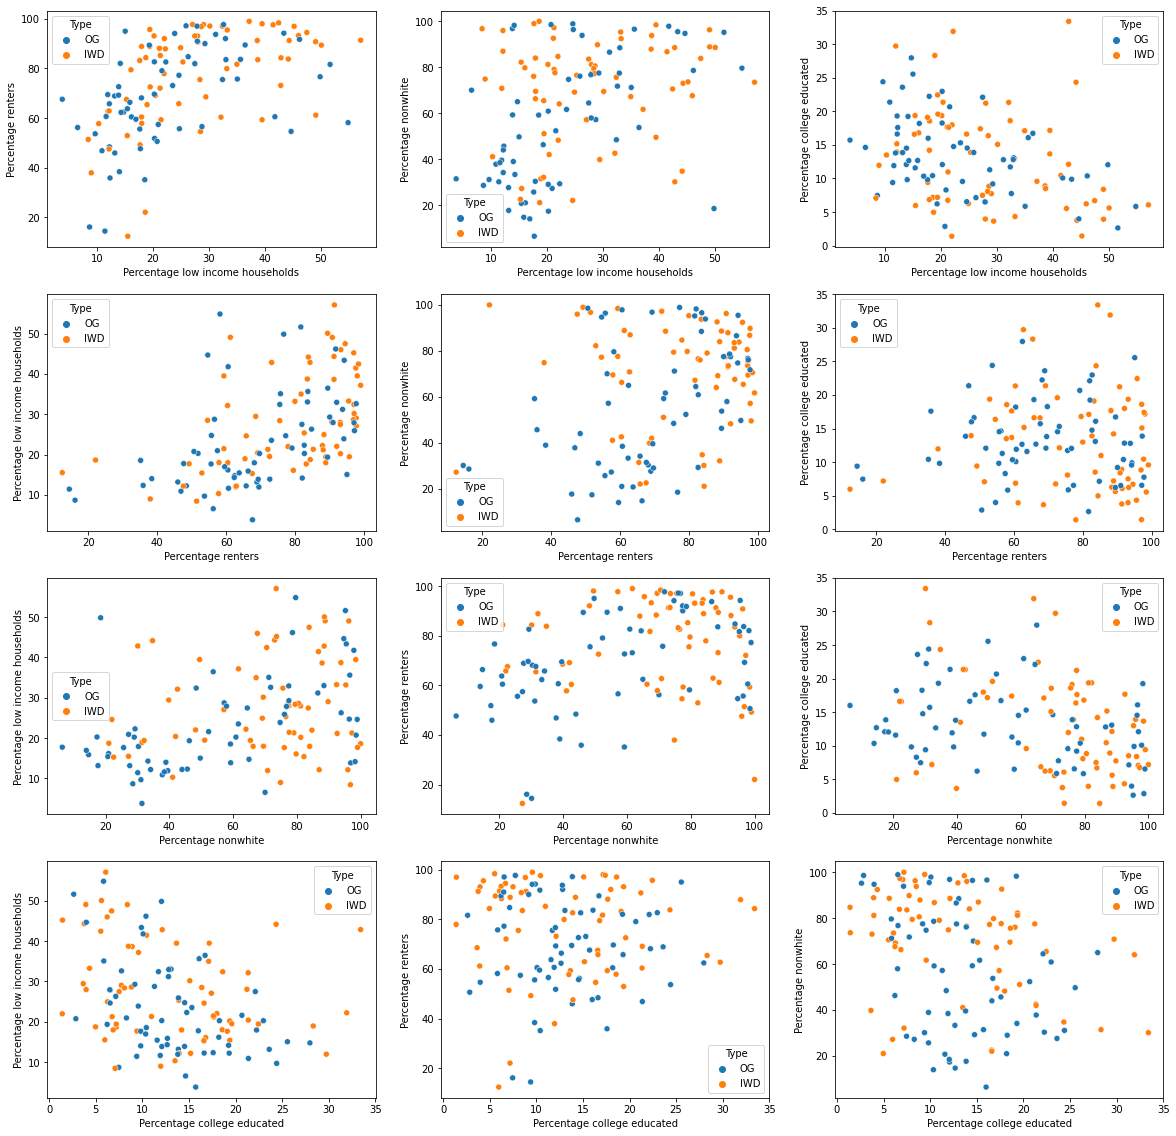

In [ ]:
percentages = ['Percentage low income households', 'Percentage renters', 'Percentage nonwhite', 'Percentage college educated']
fig, ax =plt.subplots(4,3, figsize= (20, 20))
for i, xvar in enumerate(percentages):
    for j, yvar in enumerate([x for x in percentages if x!=xvar]):
        sns.scatterplot(x=xvar, y=yvar, hue='Type', ax=ax[i][j], data=cInterestingB)

# Industry Analysis
We hypothesised that industry was a fundamental factor towards understanding the demographic resiliency that a tract had as a reaction to investment ocurring. 

In [ ]:
labels = ['Male Agriculture, forestry, fishing and hunting, and mining',
       'Male workers',
       'Male Arts, entertainment, and recreation, and accommodation and food services',
       'Female workers', ' Male Public administration',
       'Male Other services, except public administration',
       'Male Educational services, and health care and social assistance',
       'Male Information',
       'Male Transportation and warehousing, and utilities',
       'Male Professional, scientific, and management, and administrative and waste management services',
       'Male Finance and insurance, and real estate and rental and leasing',
       'Male Retail trade', 'Male Wholesale trade', 'Male Manufacturing',
       'Male Construction',
       'Female Educational services, and health care and social assistance',
       'Female Finance and insurance, and real estate and rental and leasing',
       'Female Information',
       'Female Professional, scientific, and management, and administrative and waste management services',
       'Female Transportation and warehousing, and utilities',
       'Female Retail trade', 'Female Wholesale trade', 'Female Manufacturing',
       'Female Construction',
       'Female Agriculture, forestry, fishing and hunting, and mining',
       'Female Arts, entertainment, and recreation, and accommodation and food services',
       'Female Public administration',
       'Female Other services, except public administration']

In [ ]:
base['Agriculture, forestry, fishing and hunting, and mining'] = 100*(base['Male Agriculture, forestry, fishing and hunting, and mining']+ base['Female Agriculture, forestry, fishing and hunting, and mining'])/(base['Total workers'])
base['Arts, entertainment, and recreation, and accommodation and food services'] = 100*(base['Male Arts, entertainment, and recreation, and accommodation and food services']+ base['Female Arts, entertainment, and recreation, and accommodation and food services'])/(base['Total workers'])
base['Public administration'] = 100*(base[' Male Public administration']+ base['Female Public administration'])/(base['Total workers'])
base['Other services, except public administration'] = 100*(base['Male Other services, except public administration']+ base['Female Other services, except public administration'])/(base['Total workers'])
base['Educational services, and health care and social assistance'] = 100*(base['Male Educational services, and health care and social assistance']+ base['Female Educational services, and health care and social assistance'])/(base['Total workers'])
base['Information'] = 100*(base['Male Information']+ base['Female Information'])/(base['Total workers'])
base['Transportation and warehousing, and utilities'] = 100*(base['Male Transportation and warehousing, and utilities']+ base['Female Transportation and warehousing, and utilities'])/(base['Total workers'])
base['Professional, scientific, and management, and administrative and waste management services'] = 100*(base['Male Professional, scientific, and management, and administrative and waste management services']+ base['Female Professional, scientific, and management, and administrative and waste management services'])/(base['Total workers'])
base['Finance and insurance, and real estate and rental and leasing'] = 100*(base['Male Finance and insurance, and real estate and rental and leasing']+ base['Female Finance and insurance, and real estate and rental and leasing'])/(base['Total workers'])
base['Retail trade'] = 100*(base['Male Retail trade']+ base['Female Retail trade'])/(base['Total workers'])
base['Wholesale trade'] = 100*(base['Male Wholesale trade']+ base['Female Wholesale trade'])/(base['Total workers'])
base['Manufacturing'] =100* (base['Male Manufacturing']+ base['Female Manufacturing'])/(base['Total workers'])
base['Construction'] = 100*(base['Male Construction']+ base['Female Construction'])/(base['Total workers'])

In [ ]:
base = base.drop(labels, axis=1 )

In [ ]:
percents = ['Agriculture, forestry, fishing and hunting, and mining',
       'Arts, entertainment, and recreation, and accommodation and food services',
       'Public administration',
       'Other services, except public administration',
       'Information',
        'Educational services, and health care and social assistance',
       'Transportation and warehousing, and utilities',
       'Professional, scientific, and management, and administrative and waste management services',
       'Finance and insurance, and real estate and rental and leasing',
       'Retail trade', 'Wholesale trade', 'Manufacturing',
       'Construction']

In [ ]:
base['MainIndustry'] = base[percents].idxmax(axis=1)
base.MainIndustry.value_counts()

Educational services, and health care and social assistance                                   3552
Professional, scientific, and management, and administrative and waste management services     291
Arts, entertainment, and recreation, and accommodation and food services                       169
Finance and insurance, and real estate and rental and leasing                                  158
Retail trade                                                                                   137
Construction                                                                                    95
Manufacturing                                                                                   94
Transportation and warehousing, and utilities                                                   25
Public administration                                                                           10
Other services, except public administration                                                    10
Wholesale 

<AxesSubplot:>

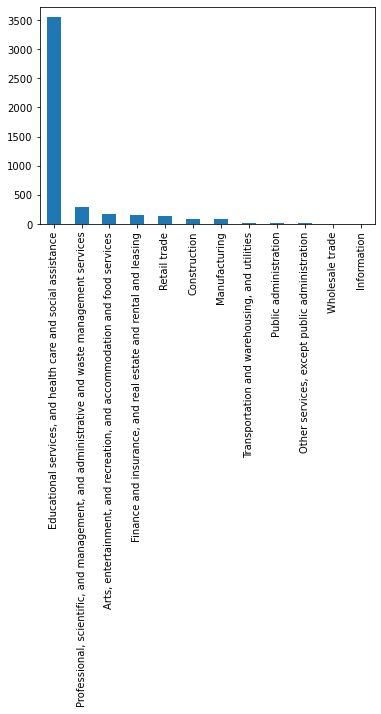

In [ ]:
base.MainIndustry.value_counts().plot.bar()

As can be observed in the above graph, Educational services is most of the times the industry that takes the most of the workers in each tract. Therefore in order to make more interesting observations we will drop that industry. 

In [ ]:
percents = ['Agriculture, forestry, fishing and hunting, and mining',
       'Arts, entertainment, and recreation, and accommodation and food services',
       'Public administration',
       'Other services, except public administration',
       'Information',
       'Transportation and warehousing, and utilities',
       'Professional, scientific, and management, and administrative and waste management services',
       'Finance and insurance, and real estate and rental and leasing',
       'Retail trade', 'Wholesale trade', 'Manufacturing',
       'Construction']

In [ ]:
base['MainIndustryAlt'] = base[percents].idxmax(axis=1)

<AxesSubplot:>

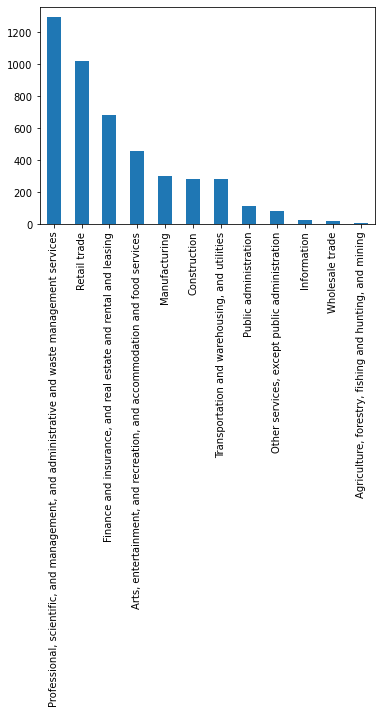

In [ ]:
base.MainIndustryAlt.value_counts().plot.bar()

In [ ]:
final['Agriculture, forestry, fishing and hunting, and mining'] = 100*(final['Male Agriculture, forestry, fishing and hunting, and mining']+ final['Female Agriculture, forestry, fishing and hunting, and mining'])/(final['Total workers'])
final['Arts, entertainment, and recreation, and accommodation and food services'] = 100*(final['Male Arts, entertainment, and recreation, and accommodation and food services']+ final['Female Arts, entertainment, and recreation, and accommodation and food services'])/(final['Total workers'])
final['Public administration'] = 100*(final[' Male Public administration']+ final['Female Public administration'])/(final['Total workers'])
final['Other services, except public administration'] = 100*(final['Male Other services, except public administration']+ final['Female Other services, except public administration'])/(final['Total workers'])
final['Educational services, and health care and social assistance'] = 100*(final['Male Educational services, and health care and social assistance']+ final['Female Educational services, and health care and social assistance'])/(final['Total workers'])
final['Information'] = 100*(final['Male Information']+ final['Female Information'])/(final['Total workers'])
final['Transportation and warehousing, and utilities'] = 100*(final['Male Transportation and warehousing, and utilities']+ final['Female Transportation and warehousing, and utilities'])/(final['Total workers'])
final['Professional, scientific, and management, and administrative and waste management services'] = 100*(final['Male Professional, scientific, and management, and administrative and waste management services']+ final['Female Professional, scientific, and management, and administrative and waste management services'])/(final['Total workers'])
final['Finance and insurance, and real estate and rental and leasing'] = 100*(final['Male Finance and insurance, and real estate and rental and leasing']+ final['Female Finance and insurance, and real estate and rental and leasing'])/(final['Total workers'])
final['Retail trade'] = 100*(final['Male Retail trade']+ final['Female Retail trade'])/(final['Total workers'])
final['Wholesale trade'] = 100*(final['Male Wholesale trade']+ final['Female Wholesale trade'])/(final['Total workers'])
final['Manufacturing'] =100* (final['Male Manufacturing']+ final['Female Manufacturing'])/(final['Total workers'])
final['Construction'] = 100*(final['Male Construction']+ final['Female Construction'])/(final['Total workers'])

## Impact of industry in the region base grouped by Type

In [ ]:
interestingB['MainIndustryAlt'] = base['MainIndustryAlt']
interestingB[percents] = base[percents]

Text(148.5, 0.5, '')

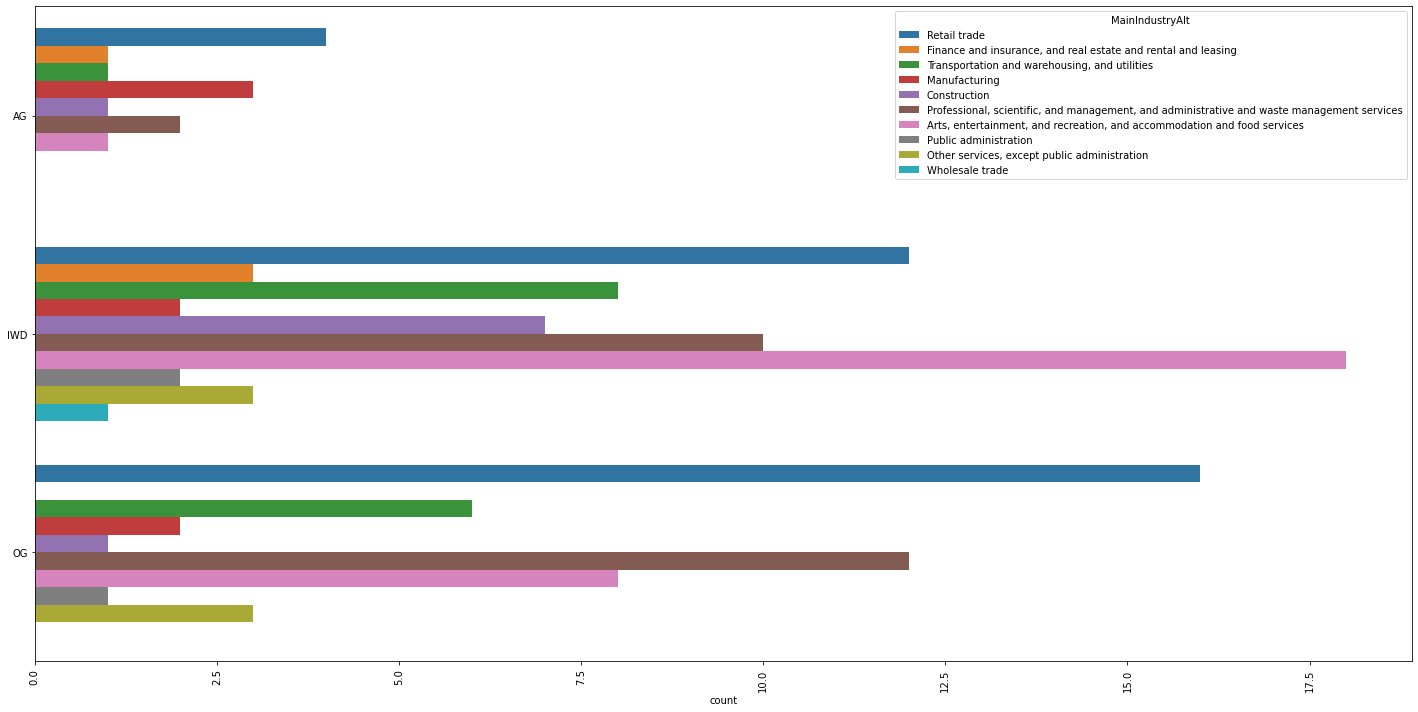

In [ ]:
plt.figure(figsize= (20, 10))
sns.countplot(hue='MainIndustryAlt', y='Type', data=interestingB)
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylabel('')

This figure reveals some key aspects regarding the impact that every industry has on the
gentrification status of the tracts. Many of the tracts going through AG or OG show a high
presence of *Retail Trade*, or *Professional, Scientific, etc.* main industries, whereas tracts where
IWD happened show a higher number of *Arts, Entertainment, etc.* professionals. 

## Probability of outcome given industry
We will now look at the individual probability of each industry to end up in one of the 3 classifications that we have defined. We will also drop those industries that have a very small sample size (less than 3).

In [ ]:
type_given_industry = [ 
   (interestingB[interestingB['MainIndustryAlt']== x]['Type'].value_counts() / interestingB[interestingB['MainIndustryAlt']== x]['Type'].count()
   ).to_dict() for x in percents]

<AxesSubplot:>

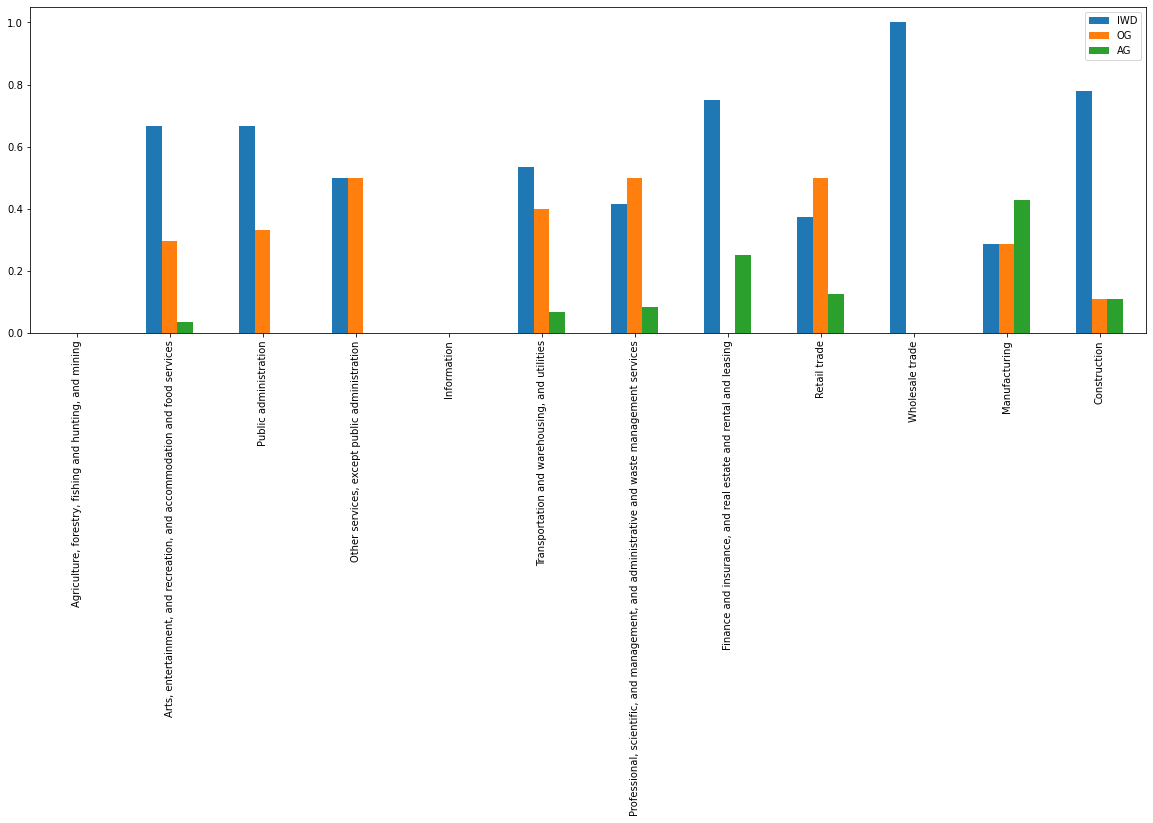

In [ ]:
pd.DataFrame(type_given_industry, index=percents).plot.bar(figsize=(20,6))

In [ ]:
[[x, interestingB[interestingB['MainIndustryAlt']== x]['Type'].count()] for x in percents]

[['Agriculture, forestry, fishing and hunting, and mining', 0],
 ['Arts, entertainment, and recreation, and accommodation and food services',
  27],
 ['Public administration', 3],
 ['Other services, except public administration', 6],
 ['Information', 0],
 ['Transportation and warehousing, and utilities', 15],
 ['Professional, scientific, and management, and administrative and waste management services',
  24],
 ['Finance and insurance, and real estate and rental and leasing', 4],
 ['Retail trade', 32],
 ['Wholesale trade', 1],
 ['Manufacturing', 7],
 ['Construction', 9]]

In [ ]:
good_percents = ['Professional, scientific, and management, and administrative and waste management services',
                 'Finance and insurance, and real estate and rental and leasing',
                 'Retail trade',
                 'Construction',
                 'Manufacturing',
                 'Transportation and warehousing, and utilities',
                 'Arts, entertainment, and recreation, and accommodation and food services',
                 'Other services, except public administration']

<AxesSubplot:>

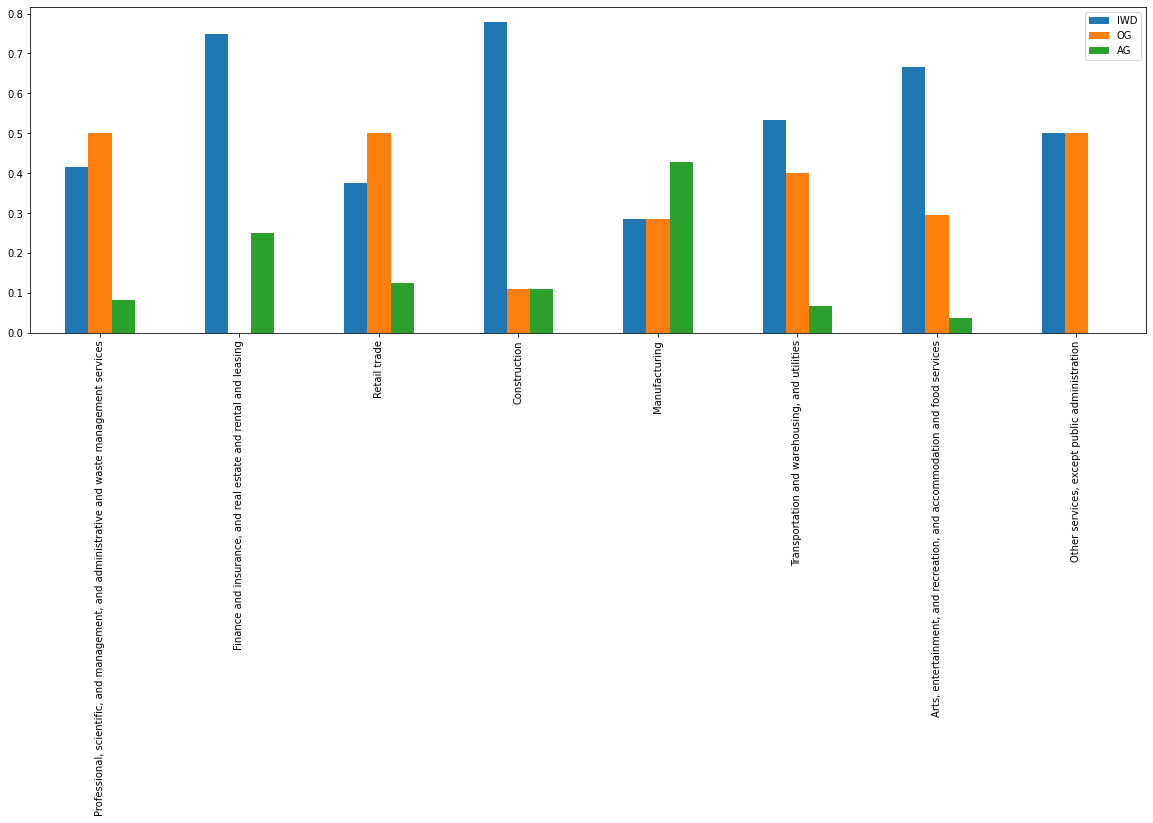

In [ ]:
pd.DataFrame(type_given_industry, index=percents).loc[good_percents].plot.bar(figsize=(20,6))

A clear pattern can be noticed. On one hand, Construction and Arts, Entertainment, etc. as well
Finance and insurance, etc. industries strongly resist displacement upon first signs of
gentrification, being the most stable when investment is injected into the tract. On the other
hand, Manufacturing, and Retail Trade, are highly liable to gentrification. While these
industries need not behave uniformly and are extremely complex and reliant on a wide variety
of conditions to explain their growth, we formulated a few hypothesis as to why this might be
the case:
- *Finance and insurance* are highly robust industries and a crucial backbone of New
York’s economy, a city that is objectively the largest financial hub in the United States
and one of the most important in the world.
- *Construction* is the industry that often materialises these investments (building more
valuable houses, renovations and such), therefore it seems intuitive that workers in such
a field would benefit from more valuable houses being built around them.
- *Retail trade* is at risk if richer people move into the neighbourhood, as these individuals
might not be satisfied by those existing family owned shops that could be replaced
easily by their preferred alternatives.
- *Manufacturing* is also at risk given the increasing land value: factories are highly relied
on their production plants. If the land rent rises, the fixed cost of operating a factory
might rise to the point where the factory owner chooses to relocate the factory to another
city, or even country to keep or improve profits. Also, richer people tend to live in ecofriendly areas, so the production lines that may harm the environment will be relocated.
As a result, those manufacturers no longer can afford to live there. 

# Linear Regression
The problem with our previous analysis was that we did not consider the rest of the other, smaller industries that certainly play a role in determining the outcome of the tract. To account for the complete distribution of the industry workers we will set up a logistic regression.

In [ ]:
import statsmodels.api as sm

In [ ]:
def model_score(predicted, label):
    score = 0
    for i, pred in enumerate(predicted):
        if round(pred) == round(label[i]):
            score += 1
    print('Score : ', score/len(label))

In [ ]:
percents = ['Agriculture, forestry, fishing and hunting, and mining',
       'Arts, entertainment, and recreation, and accommodation and food services',
       'Public administration',
       'Other services, except public administration',
       'Information',
       'Transportation and warehousing, and utilities',
       'Professional, scientific, and management, and administrative and waste management services',
       'Finance and insurance, and real estate and rental and leasing',
       'Retail trade', 'Wholesale trade', 'Manufacturing',
       'Construction']

In [ ]:
trainable = interestingB.copy()
trainable['Type'] = interestingB['Type'].apply(lambda x: 0 if (x=='AG' or x=='OG') else 1) 
x = trainable[percents]
y = trainable['Type']
x = sm.add_constant(x)
lm_1 = sm.OLS(y, x).fit()

In [ ]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Type   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     1.903
Date:                Tue, 27 Oct 2020   Prob (F-statistic):             0.0408
Time:                        10:06:02   Log-Likelihood:                -81.246
No. Observations:                 128   AIC:                             188.5
Df Residuals:                     115   BIC:                             225.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================================================
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                          0.8916      0.398      2.239      0.027       0.103       1.680
Agriculture, forestry, fishing and hunting, and mining                                        -0.0399      0.061     -0.651      0.517      -0.161       0.082
Arts, entertainment, and recreation, and accommodation and food services                       0.0155      0.009      1.737      0.085      -0.002       0.033
Public administration                                                                          0.0069      0.016      0.434      0.665      -0.025       0.038
Other services, except public administration                                                  -0.0096      0.011     -0.843      0.401      -0.032       0.013
Information                                                                                   -0.0385      0.021     -1.867      0.064      -0.079       0.002
Transportation and warehousing, and utilities                                                 -0.0041      0.012     -0.358      0.721      -0.027       0.019
Professional, scientific, and management, and administrative and waste management services    -0.0136      0.011     -1.290      0.200      -0.034       0.007
Finance and insurance, and real estate and rental and leasing                                  0.0049      0.013      0.381      0.704      -0.021       0.030
Retail trade                                                                                  -0.0240      0.011     -2.259      0.026      -0.045      -0.003
Wholesale trade                                                                                0.0262      0.018      1.438      0.153      -0.010       0.062
Manufacturing                                                                                 -0.0156      0.011     -1.466      0.145      -0.037       0.005
Construction                                                                                   0.0018      0.010      0.178      0.859      -0.018       0.021
==============================================================================
Omnibus:                      197.854   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.273
Skew:                          -0.149   Prob(JB):                      0.00357
Kurtosis:                       1.577   Cond. No.                         225.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of 

In [ ]:
lm_1.conf_int(alpha=0.05, cols=None)

,0,1
const,0.102881,1.680247
"Agriculture, forestry, fishing and hunting, and mining",-0.161382,0.081589
"Arts, entertainment, and recreation, and accommodation and food services",-0.002173,0.033149
Public administration,-0.024529,0.038287
"Other services, except public administration",-0.032016,0.012908
Information,-0.079302,0.002340
"Transportation and warehousing, and utilities",-0.027017,0.018738
"Professional, scientific, and management, and administrative and waste management services",-0.034472,0.007280
"Finance and insurance, and real estate and rental and leasing",-0.020651,0.030471
Retail trade,-0.045111,-0.002957


In [ ]:
pred = lm_1.predict(x)
model_score(pred.round().to_list(), y.to_list())

Score :  0.6953125


In [ ]:
from sklearn.model_selection import train_test_split 

In [ ]:
x = trainable[percents]
y = trainable['Type']
x = sm.add_constant(x)
X_train, X_test, y_train, y_test = train_test_split(x,  
                                                    y,  
                                                    test_size = 0.25,  
                                                    random_state = 42) 

In [ ]:
lm_1 = sm.OLS(y_train, X_train).fit()

In [ ]:
y_pred = lm_1.predict(X_test).round().to_list()
model_score(y_pred, y_test.to_list())
y_test = y_test.to_list()
y_pred = list(map(round, y_pred))
print('Acutal values', y_test) 
print('Predictions :', y_pred) 

Score :  0.59375
Acutal values [1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1]
Predictions : [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]


In [ ]:
from sklearn.metrics import (confusion_matrix,  
                           accuracy_score) 
  
# confusion matrix 
cm = confusion_matrix(y_test, y_pred)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test, y_pred))


Confusion Matrix : 
 [[11  5]
 [ 8  8]]
Test accuracy =  0.59375


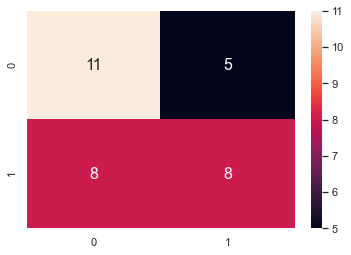

In [ ]:
df_cm = pd.DataFrame(cm, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

# Predictions
We will now attempt to predict the outcomes of the vulnerable tracts in our final year in an effort to understand how they would react to investment along the next decade.

In [ ]:
percents = ['Agriculture, forestry, fishing and hunting, and mining',
       'Arts, entertainment, and recreation, and accommodation and food services',
       'Public administration',
       'Other services, except public administration',
       'Information',
       'Transportation and warehousing, and utilities',
       'Professional, scientific, and management, and administrative and waste management services',
       'Finance and insurance, and real estate and rental and leasing',
       'Retail trade', 'Wholesale trade', 'Manufacturing',
       'Construction']

In [ ]:
x = final[percents].loc[vulnerablesFinal]
x = sm.add_constant(x)
y_pred =lm_1.predict(x)

In [ ]:
y_pred.sort_values(ascending=False).dropna()

geoid
36081005000    1.299340
36061000201    1.120874
34013006600    1.070498
36005040100    1.056847
34013003100    1.044140
                 ...   
36061007600   -0.122147
36061019701   -0.152754
34017020100   -0.305057
36061008400   -0.327768
36081022900   -0.729338
Length: 781, dtype: float64

<AxesSubplot:ylabel='Frequency'>

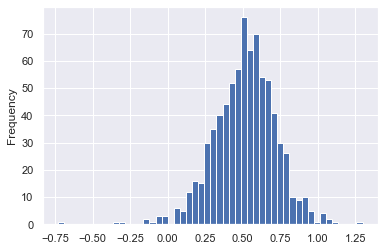

In [ ]:
y_pred.sort_values(ascending=False).dropna().plot.hist(bins=50)

In [ ]:
y_pred.to_csv('2018predictions')

<AxesSubplot:ylabel='Frequency'>

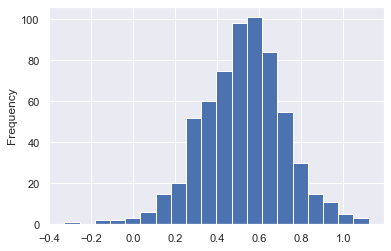

In [ ]:
adj_geoids = list(set(y_pred.index.to_list()) & set(populated))
y_pred.loc[adj_geoids].plot.hist(bins = 20)

## Conclusion

According to our investigation, the distribution of the industry where low income workers work
seems to be a key factor in determining the fate that a neighborhood will suffer upon an increase
of its wealth due to the influx of richer individuals moving in.

On one hand, Construction and Arts, Entertainment, etc. as well Finance and insurance, etc.
industries strongly resist displacement upon first signs of gentrification, being the most stable
when investment is injected into the tract. On the other hand, Manufacturing, and Retail Trade,
are highly liable to gentrification.

Therefore, in order to mitigate the effects of gentrification in New York, there are multiple
avenues concerning industry that could be explored. The direct way would be to encourage
investors (public or private) to target areas which are not at as much risk whilst discouraging
zones that are likely to suffer gentrification given their industry.

Another long-term alternative would be to incentivise industry transitions through public
investment or otherwise to gentrification-resilient industries such as Arts, Entertainment, etc.
As for the limitations of our studies, we inserted many assumptions about the classification
method that may not fully capture the effects of gentrification which still remain a topic of
discussion in the social sciences.

Another concern is the small dataset that was used for our prediction model and the fact that it
only contained information from one decade which may lead to our model not extrapolating
accurately to later decades.

We believe that with a bigger sample size (more cities that are similar to New York), taking
more variables into consideration and access to more decades we would be able to increase our
accuracy and perhaps use a more sophisticated machine learning model